# Grundwasser Analyse

In [1]:
# load packages
require(dplyr)
require(ggplot2)
require(tsibble)
require(changepoint)
require(modifiedmk)

coords = read.csv("messstellen.csv")

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: tsibble


Attaching package: ‘tsibble’


The following objects are masked from ‘package:base’:

    intersect, setdiff, union


Loading required package: changepoint

Loading required package: zoo


Attaching package: ‘zoo’


The following object is masked from ‘package:tsibble’:

    index


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Successfully loaded changepoint package version 2.2.3
 See NEWS for details of changes.

Loading required package: modifiedmk



## Breakpoints

An example of how to use a breakpoint analysis to semi-automatically identify measuring stations with errors in the raw data.

In [2]:
# load data for sachsen-anhalt
rp = read.csv("monthly/rp_monthly.csv")

In [3]:
messstelle = "rp-2377149600"

In [4]:
# get a messstelle that we already ruled out
df = rp %>%
    filter(ms_nr == messstelle) %>%
    mutate(date = paste0(year, "-", month,"-01")) %>%
    mutate(date = as.Date(date)) %>%
    tidyr::fill(mean_gwl, .direction = "downup")

In [5]:
# run changepoint test to look for sudden change in mean
cpt = cpt.mean(df$mean_gwl, penalty="SIC", method="AMOC", class=FALSE) 

In [6]:
# get p-value
p = round(1 - cpt[[2]], 4)
p

[1] 2e-04

In [7]:
# get date of sudden change in mean
ix = df[cpt[1],]$date
ix

[1] "2010-03-01"

In [8]:
# get color of line based on p-value and set chart title
col = ifelse(p < .05, "red", "blue")
title = paste0(messstelle," (p=",p,")")

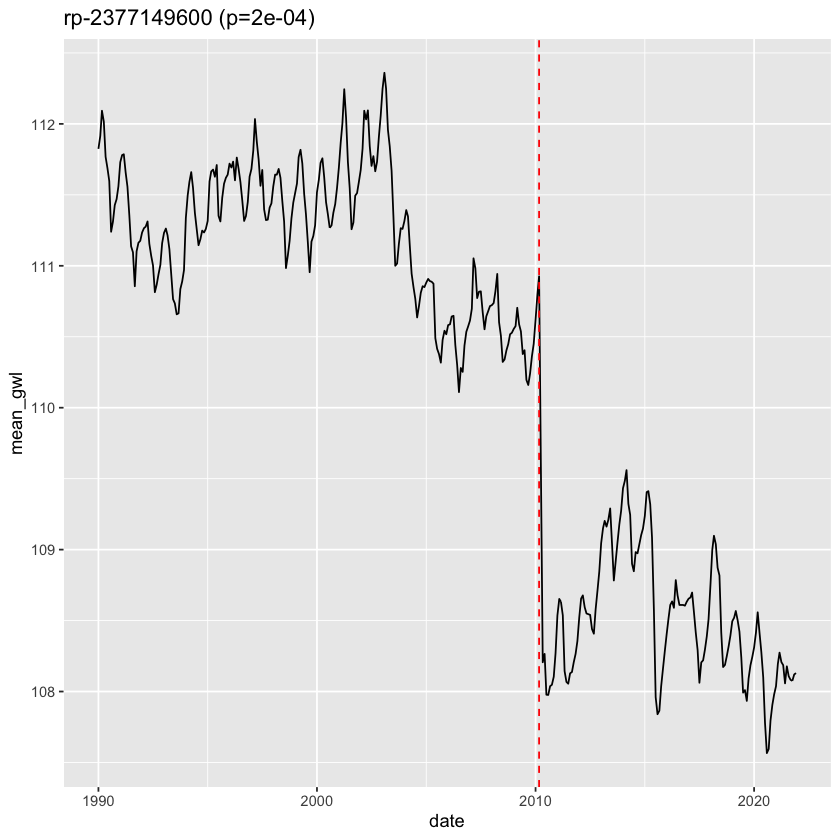

In [9]:
# plot
df %>%
    ggplot(., aes(date, mean_gwl)) +
    geom_line() +
    geom_vline(xintercept = ix, col=col, linetype="dashed") +
    ggtitle(title)

## Trend Test

An example of how we carried out our trend test.

In [10]:
# load data for brandenburg
bb = read.csv("monthly/bb_monthly.csv")

In [11]:
# get a messstelle with > 95% monthly values
coords %>%
    filter(
        behoerde == "bb",
        pct_data_1990_2021 >= .95,
        breakpoint_drop != "True",
    ) %>%
    select(ms_nr, pct_data_1990_2021, range) %>%
    head()

,ms_nr,pct_data_1990_2021,range
,<chr>,<dbl>,<dbl>
1,bb-25500006,0.9973958,1.2450
2,bb-26500002,0.9869792,2.0675
3,bb-27400050,0.9921875,1.4400
4,bb-27400058,0.9869792,1.4050
5,bb-27400059,1.0000000,0.7725
6,bb-27400064,0.9947917,2.4775


In [12]:
# choose a messstelle
messstelle = "bb-25500006"
range = 1.2450

In [13]:
# get monthly data as tsibble
ts = bb %>%
    filter(ms_nr == messstelle) %>%
    mutate(date = paste0(year, "-", month)) %>%
    mutate(date = yearmonth(date)) %>%
    as_tsibble(index=date)

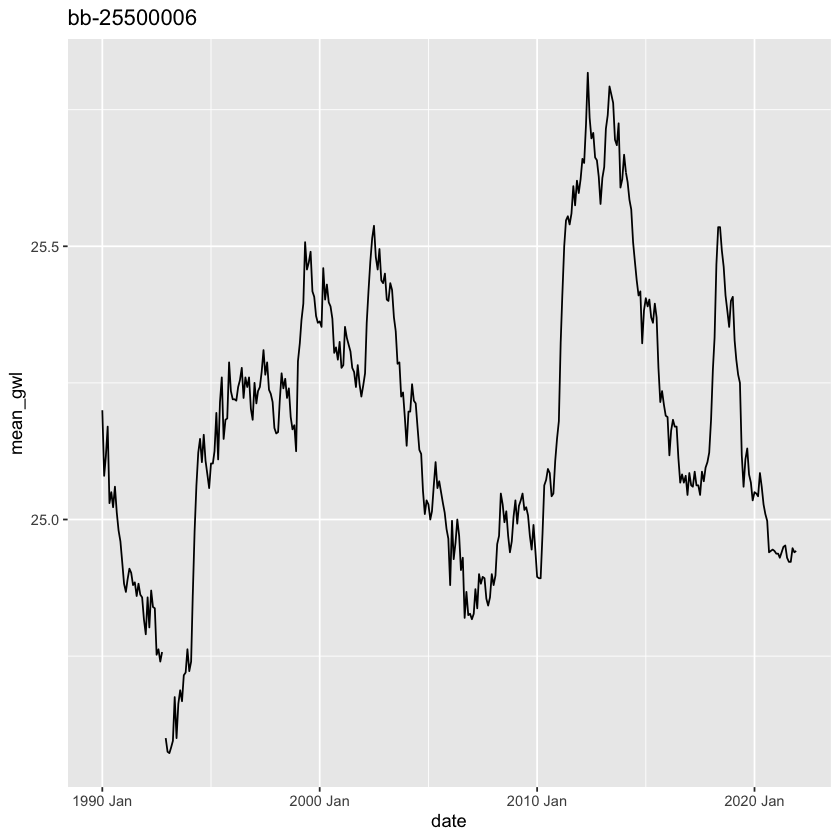

In [14]:
ts %>%
    ggplot(., aes(date, mean_gwl)) +
    geom_line() +
    ggtitle(messstelle)

In [15]:
# run test
tfpw = tfpwmk(ts$mean_gwl)
tfpw

Warning message in tfpwmk(ts$mean_gwl):
“The input vector contains non-finite numbers. An attempt was made to remove them”


Z-Value 
     17.40237800805429912998079089447855949401855468750000000000000000000000000000 
                                                                       Sen's Slope 
      0.00051632801793778443019689028403718111803755164146423339843750000000000000 
                                                                   Old Sen's Slope 
      0.00052480916030534082925007588471544295316562056541442871093750000000000000 
                                                                           P-value 
      0.00000000000000000000000000000000000000000000000000000000000000000007914787 
                                                                                 S 
  43395.00000000000000000000000000000000000000000000000000000000000000000000000000 
                                                                            Var(S) 
6217877.66666666604578495025634765625000000000000000000000000000000000000000000000 
                                                                               Tau 
      0.59632271097002931270480985403992235660552978515625000000000000000000000000

In [16]:
# function to get trend bin
get_bin = function(trend, p_value) {
    
    # if not statistically significant, no strong trend
    if (p_value > 0.05) {
        return("kein starker Trend")
    }
    
    # otherwise, get bin
    bin = cut(
        trend,
        breaks=c(-Inf, -1, -.5, .5, 1, Inf),
        labels=c("stark sinkend", "leicht sinkend", "kein starker Trend", "leicht steigend", "stark steigend"),
    )
    
    res = as.character(bin)
    
    return(res)
}

In [17]:
# get sen's slope from TFPW test and multiply by 12 to get change in meters per year
trend_raw = tfpw[[2]]*12 
trend_raw

[1] 0.006195936

In [18]:
# get p-value
p_value = tfpw[[4]]
p_value

[1] 0.00000000000000000000000000000000000000000000000000000000000000000007914787

In [19]:
# get normalized trend in % per year by dividing by range of monatsmittelwerte
trend_normalized = 100*trend_raw/range
trend_normalized

[1] 0.4976656

In [20]:
# get trend bin
bin = get_bin(trend_normalized, p_value)
bin

[1] "kein starker Trend"